In [1]:
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as o
from scipy import signal
from lmfit.models import LinearModel, LorentzianModel
import scipy.linalg as linalg

# Import data

In [2]:
mir_data = MirParser("211009_04:56:19", has_auto=True)

In [3]:
mir_data.unload_data()
mir_data.select(
    where=[
        ("sb", "eq", "u"),
        ("corrchunk","eq",4),
        ("ant", "eq",8),
        ("antrx","eq",0),
    ],
    reset=True
)
mir_data.load_data(load_auto=True, apply_tsys=False)

f_sky = (
    mir_data.ac_data['fsky'][0]
    + (np.arange(mir_data.ac_data['nch'][0]) * mir_data.ac_data['fres'][0]*1e-3)
)
f_sky = f_sky[1024:-1024]

In [4]:
sort_idx = np.argsort(mir_data.eng_data['actual_el'])

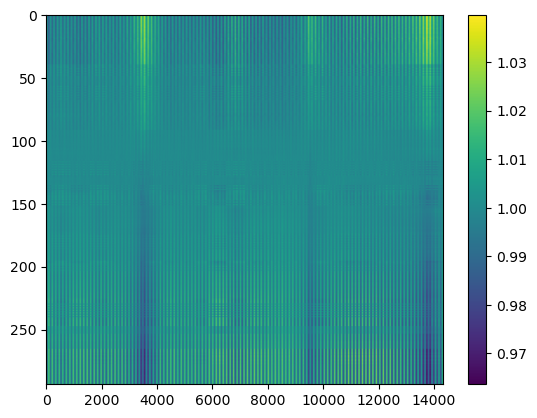

In [5]:
data_stack = np.vstack([item['data'] for item in mir_data.auto_data.values()])[:, 1024:-1024]
n_int, n_chan = data_stack.shape

data_stack = data_stack/np.repeat(np.median(data_stack,axis=0).reshape([1,-1]), n_int, axis=0)
data_stack = data_stack/np.repeat(np.median(data_stack,axis=1).reshape([-1,1]), n_chan, axis=1)

plt.imshow(data_stack[sort_idx, :], aspect='auto')
plt.colorbar()

# Manual Line Masking

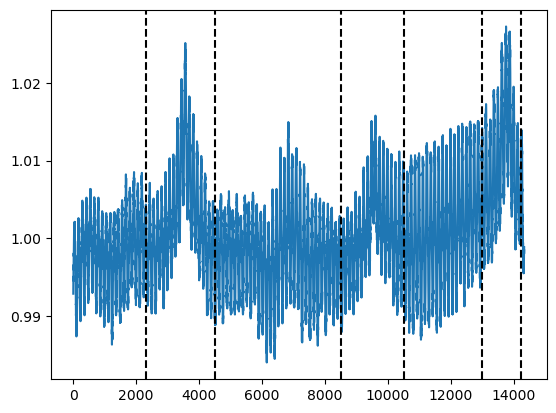

In [6]:
plt.plot(data_stack[50, :])
plt.axvline(2300, color='k', ls='--')
plt.axvline(4500, color='k', ls='--')
plt.axvline(8500, color='k', ls='--')
plt.axvline(10500, color='k', ls='--')
plt.axvline(13000, color='k', ls='--')
plt.axvline(data_stack[50, :].size-100, color='k', ls='--')

In [7]:
working_spec = 1 * data_stack
final_spec   = 1 * data_stack

ranges = [[2300, 4500], [8500, 10500], [13000, data_stack[50, :].size-5]]

baseline_indices = np.hstack([np.arange(0, 2300), np.arange(4500, 8500), np.arange(10500, 13000), np.arange(data_stack.shape[1]-100, data_stack.shape[1])])

for row in range(working_spec.shape[0]):
    p = np.polyfit(baseline_indices, data_stack[row, baseline_indices], 5)
    fit = np.poly1d(p)
    working_spec[row, baseline_indices] = data_stack[row, baseline_indices] - fit(baseline_indices)
    working_spec[row, baseline_indices] -= np.nanmean(working_spec[row, baseline_indices])

    final_spec[row, :] = data_stack[row, :] - fit(np.arange(data_stack.shape[1]))
    
    #Now mask lines regions
    for range_i in ranges:
        low, high = range_i[0], range_i[1]
        working_spec[row , low : high] = 0

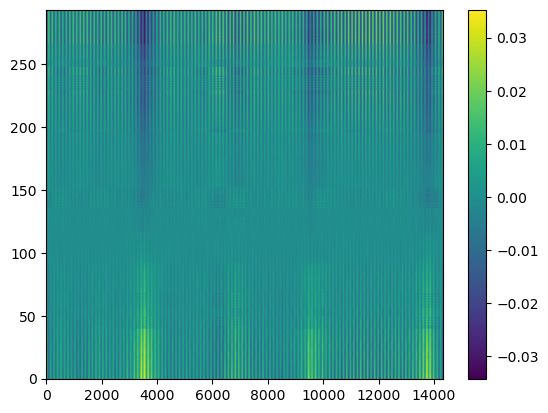

In [8]:
plt.imshow(final_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

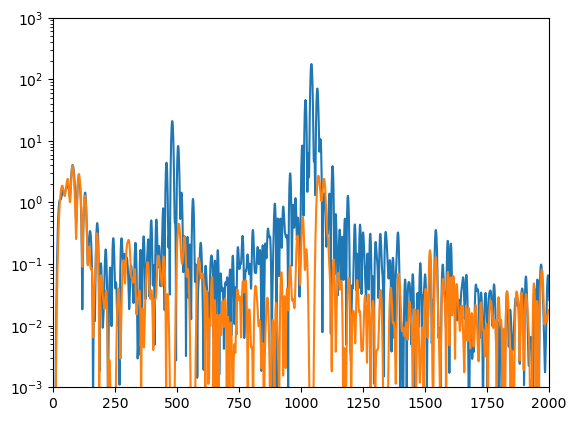

In [11]:
#Local copy
show_plot = True
specnum = 100
data = 1 * working_spec[None, specnum]
num_comps = 1
f0_list = [(1 / 17.8), (2 / 17.8), (3 / 17.8), (4 / 17.8), (5 / 17.8), (1 / 63.1), (1 / 36.6), (2 / 63.1), (1/17.8) + (1/63.1)]
polyorder_list = [4] * len(f0_list)
# polyorder_list[0] = 10
base_polyorder = 6
fft_window = (1 / 63.2) * 0.2

#Padding size -- don't do anything if the data are already a 2^n size
highest_n = int(np.ceil(np.log2(data.shape[1]))) + 3

left_pad = int(np.ceil(((2**highest_n) - data.shape[-1]) * 0.5))
right_pad = int(np.floor(((2**highest_n) - data.shape[-1]) * 0.5))
pad_slice = slice(left_pad, -right_pad)

#Stores final model and residual arrays
#model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
#resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
model_store = np.zeros(data.shape)
                        
#Stores *actual* FFT frequencies for model below
fftfreqs = np.fft.fftfreq(int(2**highest_n), d = 1e3 * np.abs(np.diff(f_sky)[0]))

freqs_pad = f_sky[0] + np.diff(f_sky)[0] * np.arange(0, 2**highest_n)

f_sky_norm = 2 * (freqs_pad - min(freqs_pad[pad_slice])) / (max(freqs_pad[pad_slice]) - min(freqs_pad[pad_slice])) - 1

for integ in range(data.shape[0]):
    #Data -- Pad integration time
    padded_integ = np.pad(data[integ, :], (left_pad, right_pad))
    fitting_mask = np.nonzero(padded_integ)
    padded_integ[fitting_mask] -= np.nanmean(padded_integ[fitting_mask])

    #Padded FFT
    padded_fft = np.fft.fft(padded_integ)
    
    #Model -- Padded model 
    model = np.zeros(padded_integ.size, dtype='complex128')
    A = np.zeros((padded_integ.size, 2 * (sum(polyorder_list) + len(f0_list)) + base_polyorder))
    for basis in range(base_polyorder):
        A[:, -(1+basis)] = f_sky_norm**basis
    
    psd = np.abs(padded_fft)**2.0    
    for idx, f0 in enumerate(f0_list):
        polyorder = polyorder_list[idx]
        model_fft = np.zeros(padded_fft.size, dtype='complex128')
        
        #Make window around |f0 * (1 + harmonic)| to search for peaks using a priori information
        selection_window = (fftfreqs >= (f0 - fft_window)) & (fftfreqs <= (f0 + fft_window))
        peak_amp = np.nanmax(psd[selection_window])
        peak_amp_position = np.where((psd == peak_amp) & selection_window)[0][0]
        #plt.plot(selection_window*1e1*(1+harmonic))
        
        #Model from FFT peak above
        model_fft[[peak_amp_position, -peak_amp_position]] = padded_fft[[peak_amp_position, -peak_amp_position]]

        model_re = np.fft.ifft(model_fft.real).real
        model_im = np.fft.ifft(1j * model_fft.imag).real

        for basis in range(polyorder + 1):
            A[:, 2 * idx * (polyorder + 1) + 2 * basis]     = model_im * f_sky_norm**basis
            A[:, 2 * idx * (polyorder + 1) + 2 * basis + 1] = model_re * f_sky_norm**basis
    
    #b is the actual data, so no need to calculate residual
    res = linalg.lstsq(A[fitting_mask, :][0], padded_integ[fitting_mask])
    polyvalues = res[0]
    model_store[integ, :] = np.matmul(A, polyvalues)[pad_slice]
    
    if show_plot:
        before = abs(np.fft.fft(padded_integ))**2.0
        plt.semilogy(before)
        padded_integ[fitting_mask] -= np.matmul(A, polyvalues)[fitting_mask]
        after = abs(np.fft.fft(padded_integ))**2.0
        plt.semilogy(after)
        plt.xlim([0, 2000])
        plt.ylim([1e-3, 1e3])


(234.5, 236.0)

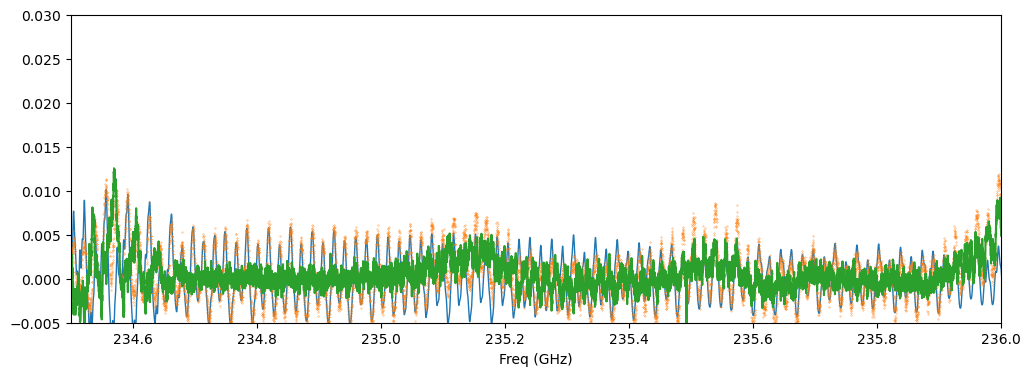

In [15]:
plt.figure(figsize=[12,4])
#padded_integ[fitting_mask] += np.matmul(A, polyvalues)[fitting_mask]
#plt.plot(padded_integ[pad_slice])
plt.plot(f_sky, model_store[0], linewidth=1)
#padded_integ[fitting_mask] -= np.matmul(A, polyvalues)[fitting_mask]
#plt.plot(padded_integ[left_pad:-right_pad])
plt.plot(f_sky, final_spec[specnum], '.', linewidth=1, markersize=0.5)
plt.plot(f_sky, final_spec[specnum] - model_store[0])
plt.ylim([-0.005, 0.030])
#plt.xlim([8000, 11000])
plt.xlabel('Freq (GHz)')
plt.xlim([234.5, 236])


Text(0.5, 1.0, 'After subtraction')

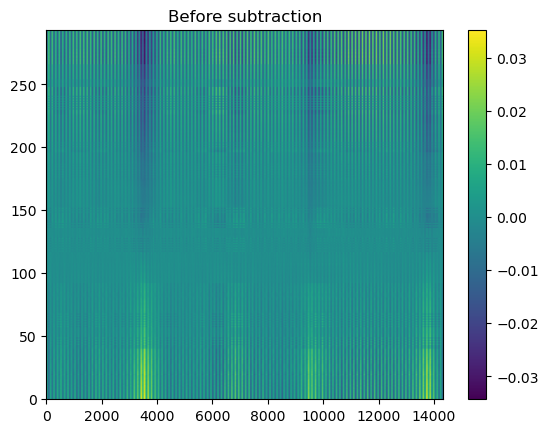

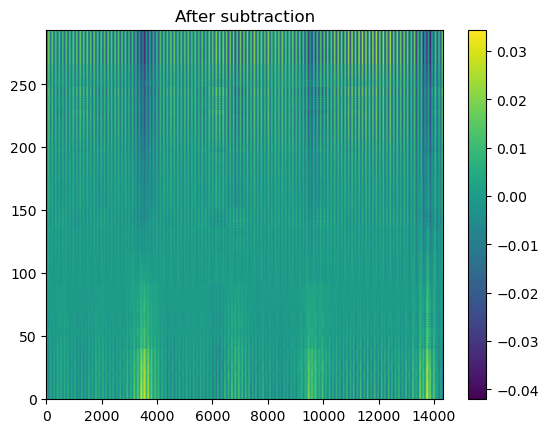

In [13]:
plt.imshow(final_spec[sort_idx], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Before subtraction')
#plt.ylim([200, 205])
plt.figure()
plt.imshow(final_spec[sort_idx]-model_store[0], origin='lower', aspect='auto')
plt.colorbar()
plt.title('After subtraction')


In [684]:
1/(fftfreqs[1] * 100), 1/(fftfreqs[1] * 390), 1/(fftfreqs[1] * 1030) 

(np.float64(183.0400000140071),
 np.float64(46.933333336924896),
 np.float64(17.77087378776768))

In [612]:
1030 - ( 390)

640